# Exploratory Data Analysis and Topic Modeling

This section will cover:
* initial exploratory analysis
* grammar and spelling correction 
* feature extraction with SpaCy 
* topic modeling with latent Dirichlet allocation (LDA).
* automatic scoring with LDA

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_check

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

import pyLDAvis
from pyLDAvis.sklearn import prepare

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

pyLDAvis.enable_notebook()
# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']= 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [4]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,err_ratio,avg_len,total_err_ratio,avg_wdlen,count_vector
0,0,0,0,0,0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.026627218934911243, 0.005917159763313609)",30.818182,0.032544,4.387574,"(0, 19929)\t1\n (0, 13868)\t1\n (0, 33918)\t1\n (0, 14798)\t1\n (0, 4818)\t1\n (0, 20893)..."
1,1,1,1,1,1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.03341288782816229, 0.011933174224343675)",22.052632,0.045346,4.353222,"(0, 20235)\t1\n (0, 26185)\t1\n (0, 26031)\t1\n (0, 22230)\t1\n (0, 14724)\t1\n (0, 29841..."
2,2,2,2,2,2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0035842293906810036, 0.02867383512544803)",18.533333,0.032258,4.405018,"(0, 36230)\t1\n (0, 29755)\t1\n (0, 7980)\t1\n (0, 36919)\t1\n (0, 20046)\t1\n (0, 35158)..."
3,3,3,3,3,3,4,1,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.04580152671755725, 0.02099236641221374)",21.040000,0.066794,4.868321,"(0, 34683)\t1\n (0, 21557)\t1\n (0, 8232)\t1\n (0, 32709)\t1\n (0, 27348)\t1\n (0, 6516)\..."
4,4,4,4,4,4,5,1,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.025806451612903226, 0.010752688172043012)",14.903226,0.036559,4.408602,"(0, 36306)\t1\n (0, 22533)\t1\n (0, 28070)\t1\n (0, 36309)\t1\n (0, 13669)\t1\n (0, 3944)..."


In [5]:
training_set.shape

(12976, 38)

In [6]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 38 columns):
Unnamed: 0            12976 non-null int64
Unnamed: 0.1          12976 non-null int64
Unnamed: 0.1.1        12976 non-null int64
Unnamed: 0.1.1.1      12976 non-null int64
Unnamed: 0.1.1.1.1    12976 non-null int64
essay_id              12976 non-null int64
topic                 12976 non-null int64
essay                 12976 non-null object
rater1_domain1        12976 non-null int64
rater2_domain1        12976 non-null int64
rater3_domain1        128 non-null float64
target_score          12976 non-null int64
rater1_domain2        1800 non-null float64
rater2_domain2        1800 non-null float64
topic2_target         1800 non-null float64
rater1_trait1         2292 non-null float64
rater1_trait2         2292 non-null float64
rater1_trait3         2292 non-null float64
rater1_trait4         2292 non-null float64
rater1_trait5         723 non-null float64
rater1_trait6         7

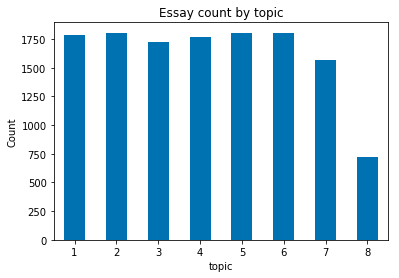

In [9]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [8]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

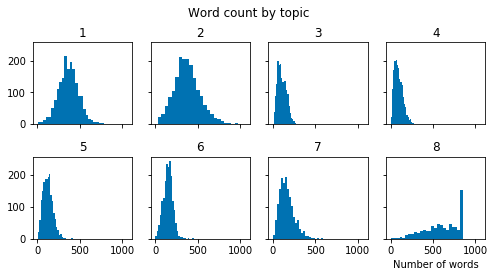

In [10]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


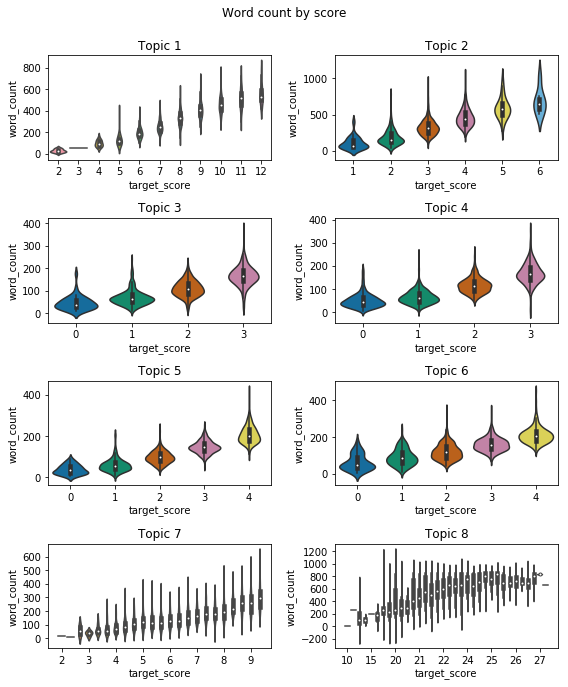

In [9]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see a reasonable correlation between word count and score for all but topic 8 where the word count apparently reaches a maximum at the upper third of the scores.

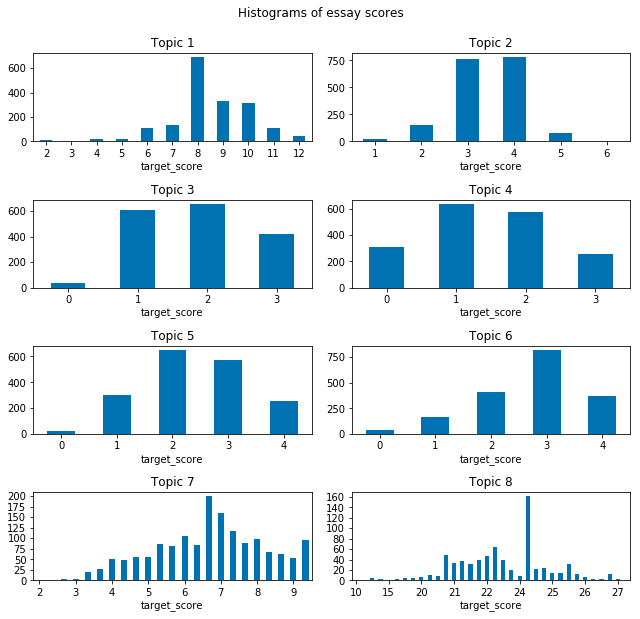

In [10]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()